<a id='Top'></a>

# <font color="#8333ff">P9: Prédisez la demande en éléctricité</font>

---

## Sommaire

[1. Préparation des données](#1.Preparationdesdonnees) 

[2. Mission](#2.Mission)  
- [1. Corriger les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire](#1.regressionlineaire) 
- [2. Désaisonnalisation de la consommation obtenue après correction grâce aux moyennes mobiles](#2.Désaisonnalisation)
- [3. Prévision de la consommation (corrigée de l'effet température) sur un an](#3.Previsiondelaconsommation)  
 - [en utilisant la méthode de Holt Winters (lissage exponentiel)](#HoltWinters) 
 - [puis la méthode SARIMA](#SARIMA)

---

In [2]:
# Import des librairies standards
import numpy as np
print(f"numpy version {np.__version__}")
import pandas as pd
print(f"pandas version {pd.__version__}")
import seaborn as sns
print(f"seaborn version {sns.__version__}")
import matplotlib.pyplot as plt

# Fonctions créées pour ce projet
from functions import *

# Pour Shapiro
import scipy.stats as st
from scipy.stats import shapiro

import statsmodels.stats.api as sms

# Pour la recherche de paramètres SARIMA
from pmdarima import auto_arima

# Désactivation FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

numpy version 1.18.1
pandas version 1.0.1
seaborn version 0.10.0


Pour chaque traitement effectué (correction de l'effet température, désaisonnalisation, etc.), **présenter les 2 séries temporelles avant et après traitement, sur un graphique où les deux séries temporelles seront superposées.**

<a id='1.Preparationdesdonnees'></a>

# <font color='#FFCA36'>1. Préparation des données</font>

## Données de consommation mensuelles 

Source : https://www.rte-france.com/fr/eco2mix/eco2mix-telechargement  
RTE est la société publique gérant le réseau de transport d'électricité de France. 

In [2]:
# Import des données
conso = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P9/eCO2mix_RTE_energie_M.csv', sep=';')

In [3]:
conso.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,0000-00,Données consolidées,Grand-Est,11346,8643.0,1120,22.0,2,1095,565,...,86,4545,6711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données consolidées,Nouvelle-Aquitaine,5289,4179.0,164,NaN,0,164,419,...,120,4578,711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données consolidées,Auvergne-Rhône-Alpes,11622,8382.0,334,6.0,11,316,2630,...,104,6834,4483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000-00,Données consolidées,Bourgogne-Franche-Comté,467,NaN,124,NaN,0,123,89,...,31,2188,-1724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000-00,Données consolidées,Bretagne,535,NaN,182,NaN,4,178,59,...,36,2443,-1915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
conso.shape

(1156, 22)

In [4]:
# Suppression des lignes avec des mois incohérents, des lignes autres que "France" et 
# des colonnes autres que "Mois" et "conso totale"
conso = conso.loc[(conso['Mois']!='0000-00') & (conso['Territoire']=='France'), ['Mois', 'Consommation totale']]

In [5]:
# Reset index
conso.reset_index(drop = True, inplace=True)

In [6]:
conso.head()

,Mois,Consommation totale
0,2012-01,51086
1,2012-02,54476
2,2012-03,43156
3,2012-04,40176
4,2012-05,35257


In [7]:
# Je renomme les colonnes
conso.columns = ['mois', 'consommation']

In [7]:
conso.tail()

,mois,consommation
94,2019-11,44180
95,2019-12,47096
96,2020-01,49748
97,2020-02,43385
98,2020-03,41516


In [9]:
conso.describe()

,consommation
count,99.000000
mean,40177.828283
std,7060.872373
min,31004.000000
25%,33797.500000
50%,37875.000000
75%,45524.500000
max,57406.000000


In [10]:
# Présence de données nulles ?
conso.isnull().sum()

mois            0
consommation    0
dtype: int64

In [11]:
# Types
conso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mois          99 non-null     object
 1   consommation  99 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [8]:
# Je transforme le type de la colonne mois en datetime
conso.mois = pd.to_datetime(conso.mois)

In [13]:
# Vérification
conso.dtypes

mois            datetime64[ns]
consommation             int64
dtype: object

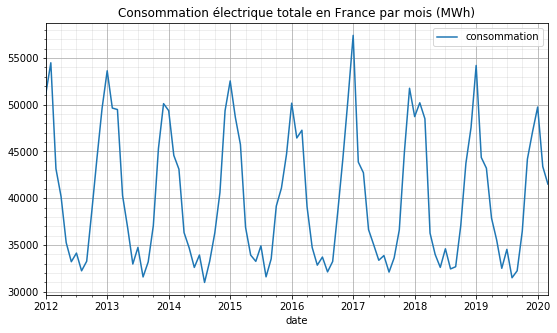

In [11]:
# Visualisation des données
conso.plot(x = 'mois', figsize=(9,5))
plt.title('Consommation électrique totale en France par mois (MWh)')
plt.xlabel('date')
# plt.ylabel('consommation')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# plt.savefig('fig1.jpeg')

On observe une saisonnalité de période 12 et une tendance stable. 

## Données météo pour corriger les données de l'effet température

Source : https://cegibat.grdf.fr/simulateur/calcul-dju

**Le degré jour unifié (DJU)** est la différence entre la température extérieure et une température de référence qui permet de réaliser des estimations de consommations d'énergie thermique pour maintenir un bâtiment confortable en proportion de la rigueur de l'hiver ou de la chaleur de l'été. **La référence habituelle de 18 °C** fut définie en considérant que la température intérieure des locaux est à 19 °C et que les apports gratuits internes (occupants, éclairage, équipements, etc.) et externes (rayonnement solaire, etc.) couvrent l'équivalent de 1 °C de déperditions thermiques. 

Dans la méthode « météo », pour chaque période de 24 heures, le nombre de DJU est déterminé en faisant la différence entre la température de référence, par exemple 18 °C, et la moyenne de la température minimale et la température maximale de ce jour. **C'est donc une estimation de la différence entre la température intérieure de référence - hors apports naturels et domestiques - et la température extérieure médiane de la journée.**

Le DJU pour chaque mois est la somme des DJU quotidiens. 

cf. Wikipedia : https://fr.wikipedia.org/wiki/Degr%C3%A9_jour_unifi%C3%A9

In [38]:
# Import des données
dju = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P9/DJU_Paris.csv', sep=';')

In [39]:
dju

,Année,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
0,2019,404.9,268.3,233.1,168.5,117.9,14.0,0.0,0.0,0.0,0.0,0.0,0.0,1206.6
1,2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9,2002.2
2,2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0,2040.6
3,2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8,2207.3
4,2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1,1986.2
5,2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2,1811.5
6,2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5,2424.8
7,2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9,2191.5
8,2011,392.0,304.8,243.1,77.6,43.4,31.4,15.0,11.9,23.2,127.6,226.6,312.7,1809.0
9,2010,499.2,371.4,294.5,165.3,140.9,22.6,0.0,11.1,52.3,172.2,310.0,512.0,2551.1


In [40]:
# Je supprime la colonne "Total" : 
dju.drop('Total', axis = 1, inplace=True)

In [41]:
# Je renomme les colonnes : 
dju.columns = ['annee', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [42]:
# Vérification
dju.head()

,annee,01,02,03,04,05,06,07,08,09,10,11,12
0,2019,404.9,268.3,233.1,168.5,117.9,14.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9
2,2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0
3,2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8
4,2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1


In [43]:
# Je mets les mois en ligne avec le fonction melt (l'inverse de pivot table)
# cf. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html
dju = pd.melt(dju, id_vars='annee', var_name='Mois', value_name='dju')

In [44]:
dju.head()

,annee,Mois,dju
0,2019,01,404.9
1,2018,01,303.4
2,2017,01,467.9
3,2016,01,364.4
4,2015,01,392.0


In [45]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   annee   132 non-null    int64  
 1   Mois    132 non-null    object 
 2   dju     132 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ KB


In [46]:
# Je modifie le type de la colonne annee pour pouvoir la concaténer avec Mois
dju['annee'] = dju['annee'].astype('str')

In [47]:
# Concaténation
dju['date'] = dju['annee'] + '-' + dju['Mois']

In [48]:
# Suppression des colonnes inutiles
dju = dju.drop(['annee', 'Mois'], axis=1)

In [49]:
dju.dtypes

dju     float64
date     object
dtype: object

In [50]:
# Je transforme le type date
dju.date = pd.to_datetime(dju.date)

In [51]:
dju.head()

,dju,date
0,404.9,2019-01-01
1,303.4,2018-01-01
2,467.9,2017-01-01
3,364.4,2016-01-01
4,392.0,2015-01-01


In [52]:
dju.tail()

,dju,date
127,349.5,2013-12-01
128,345.9,2012-12-01
129,312.7,2011-12-01
130,512.0,2010-12-01
131,411.8,2009-12-01


In [29]:
dju.shape

(132, 2)

In [53]:
# Nous avons vu précédemment que les dernières dates ont un dju = 0, on ne les prendra pas en compte
dju[dju['date'] > '2019-03-01']

,dju,date
33,168.5,2019-04-01
44,117.9,2019-05-01
55,14.0,2019-06-01
66,0.0,2019-07-01
77,0.0,2019-08-01
88,0.0,2019-09-01
99,0.0,2019-10-01
110,0.0,2019-11-01
121,0.0,2019-12-01


In [54]:
# Je vais limiter les données à juin 2019
dju = dju[dju['date'] < '2019-07-01']

In [55]:
dju.shape

(126, 2)

In [56]:
dju.describe()

,dju
count,126.000000
mean,178.201587
std,147.688615
min,0.000000
25%,32.125000
50%,156.500000
75%,303.775000
max,512.000000


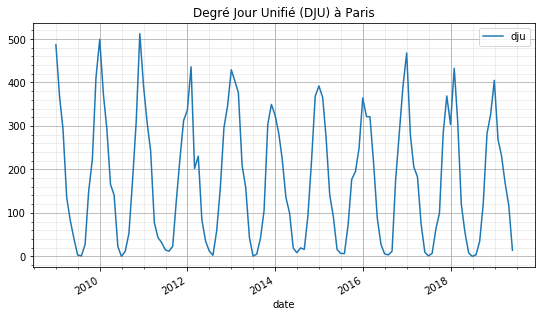

In [57]:
# Visualisation des données
dju.plot(x='date', figsize=(9,5))
plt.title('Degré Jour Unifié (DJU) à Paris')

plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# plt.savefig('fig2.jpeg')

On observe aussi une saisonnalité de période 12. La tendance est semblable à celle de la consommation d'énergie : les 2 variables semblent corrélées. 

In [58]:
# le jointure des 2 df via inner permet de ne garder que les données qui existent des 2 cotés. 
data = pd.merge(conso, dju, left_on='mois', right_on='date', how='inner')

In [59]:
data.head()

,mois,consommation,dju,date
0,2012-01-01,51086,336.0,2012-01-01
1,2012-02-01,54476,435.9,2012-02-01
2,2012-03-01,43156,201.9,2012-03-01
3,2012-04-01,40176,230.3,2012-04-01
4,2012-05-01,35257,83.3,2012-05-01


In [60]:
# On supprime la 2ème occurrence de la date
data.drop('date', axis = 1, inplace=True)

In [61]:
data.tail()

,mois,consommation,dju
85,2019-02-01,44356,268.3
86,2019-03-01,43211,233.1
87,2019-04-01,37875,168.5
88,2019-05-01,35543,117.9
89,2019-06-01,32514,14.0


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   mois          90 non-null     datetime64[ns]
 1   consommation  90 non-null     int64         
 2   dju           90 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.8 KB


In [63]:
# On met la date en index
data.set_index('mois', inplace=True)

In [5]:
data.shape

(90, 2)

90 lignes => 90 mois.

In [64]:
data.head()

,consommation,dju
mois,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3


Nos données vont donc de janvier 2012 à juin 2019. 

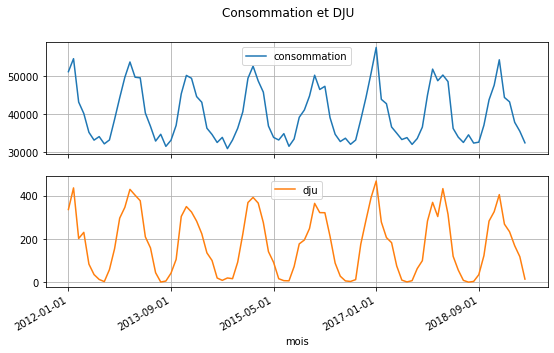

In [5]:
# On projette conso et DJU sur un même plan pour voir
data.plot(figsize = (9,5), subplots=True, grid = True)
plt.suptitle("Consommation et DJU")

plt.savefig('fig2b.jpeg')

In [45]:
# Enregistrement
data.to_csv('C:/Users/Zang/Documents/APPRENDER/OPENCLASSROOMS/PARCOURS DA/P9_Predisez_la_demande_en_electricite/data.csv')

In [24]:
data.head()

,consommation,dju
mois,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3


In [3]:
# Import (si besoin)
data = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P9/data.csv', index_col='mois')

In [4]:
data.head(1)

,consommation,dju
mois,,
2012-01-01,51086,336.0


<a id='2.Mission'></a>

[Haut de page](#Top) 

# <font color='#FFCA36'>2. Mission</font>

<a id='1.regressionlineaire'></a>

## 1. Corriger les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire

cf. par ex. http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Python_StatsModels.pdf

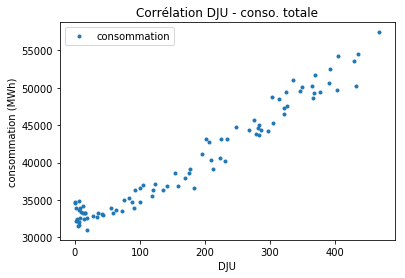

In [50]:
# Visualisation de la corrélation entre DJU et conso
data.plot(x='dju', y='consommation', style='.')
plt.xlabel('DJU')
plt.ylabel('consommation (MWh)')
# plt.legend('')
plt.title('Corrélation DJU - conso. totale')

# plt.savefig('fig3.jpeg')

### Régression linéaire

In [4]:
import statsmodels.api as sm

In [7]:
# cf. https://openclassrooms.com/fr/courses/5873596-design-effective-statistical-models-to-understand-your-data/6229141-build-and-interpret-a-univariate-linear-regression-model
# variable explicative
X = data.dju 
# ajout d'une constante
X = sm.add_constant(X)
# variable cible
y = data.consommation

# définition du modèle
model = sm.OLS(y, X)

# On fit le modèle
results = model.fit()

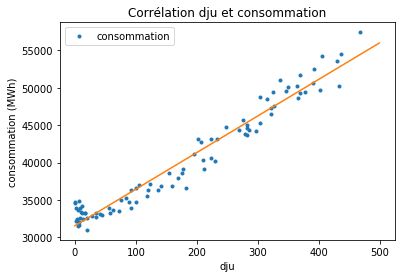

In [54]:
# Droite de régression linéaire
data.plot(x = 'dju', y = 'consommation', style = '.')
xs = np.arange(0,500)
ys = results.params[0] + results.params[1] * xs
plt.plot(xs,ys)
plt.title('Corrélation dju et consommation')
plt.ylabel('consommation (MWh)')
# plt.legend('')

# plt.savefig('fig4.jpeg')

Même chose avec Seaborn (plus directement, cf. https://openclassrooms.com/fr/courses/5873596-design-effective-statistical-models-to-understand-your-data/6229141-build-and-interpret-a-univariate-linear-regression-model)

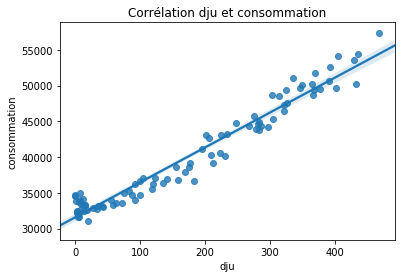

In [37]:
sns.regplot(x = data.dju, y = data.consommation).set_title('Corrélation dju et consommation')

plt.savefig('fig5.jpeg')

#### Significativité du modèle

In [8]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1818.
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           1.49e-60
Time:                        15:51:00   Log-Likelihood:                -787.41
No. Observations:                  90   AIC:                             1579.
Df Residuals:                      88   BIC:                             1584.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.156e+04    259.551    121.607      0.0

**Vérification des paramètres "de base" :** 

- Le R2 est de 0.95, ce qui est très significatif et a priori une bonne nouvelle.
cf. https://statisticsbyjim.com/regression/r-squared-too-high/
- Prob (F-statistic) est très bas. 
- les t-tests effectuées sur les coefficients renvoient une p-valeur de 0.  
=> Avant analyse des résidus, il semble que le DJU soit significatif pour expliquer la consommation électrique
   
- Durbin-Watson test = 1.914 => les résidus ne sont pas autocorrélés.
- Le test Jarque-Bera (JB) teste que les résidus ont le skewness et le kurtosis d'une distribution normale. Le test JB de notre modèle a une p-valeur de 0.576, plus que le seuil de 0.05. **Nous ne pouvons pas rejeter H0 selon laquelle la distribution des résidus est conforme à une distribution normale.** 

### Analyse des résidus

cf. :
- https://openclassrooms.com/fr/courses/5873596-design-effective-statistical-models-to-understand-your-data/6229141-build-and-interpret-a-univariate-linear-regression-model
- https://medium.com/@aurliegiraud/perform-regression-diagnostics-and-tackle-uncertainties-of-linear-models-1372a03b1f56

**Rappel**

Les résidus d'une régression linéaire correcte doivent être : 
- distribués selon une loi **normale** (donc avec une variance qui tend vers 1 et une moyenne qui tend vers 0)
- **indépendants** (pas d'autocorrélation)
- avec une **variance constante** (homoscédasticité).   

Dans le cas d'une régression linéaire multiple il faut aussi ajouter : 
- abscence de multicollinéarité. 

Mais avant tout, vérifions **la linéarité de nos données**. 

##### Linéarité

In [14]:
# Test Harvey-Collier
sms.linear_harvey_collier(results)

Ttest_1sampResult(statistic=-0.5624238684363322, pvalue=0.5752903875086055)

La p-value est > 0.05 => la condition de linéarité est vérifiée. 

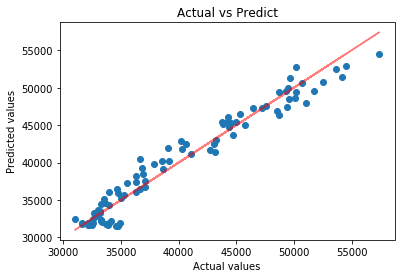

In [38]:
# Plot Predicted values VS Real values
fig, ax = plt.subplots()
plt.scatter(data['consommation'], results.predict())
plt.plot(data['consommation'], data['consommation'], color = 'r', alpha = 0.5)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predict")
plt.savefig('fig5a.jpeg')

Les points sont distribués le long de la diagonale, ce qui signifie que la condition de linéarité est potentiellement vérifiée. 

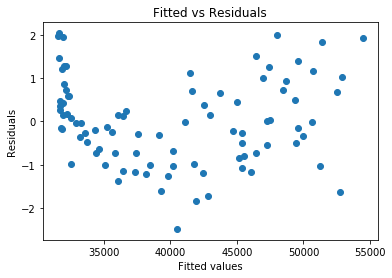

In [44]:
# Studentized residuals vs Fitted values
fig, ax = plt.subplots()
plt.scatter(results.fittedvalues, results.resid_pearson)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residuals")
plt.savefig('fig5b.jpeg')

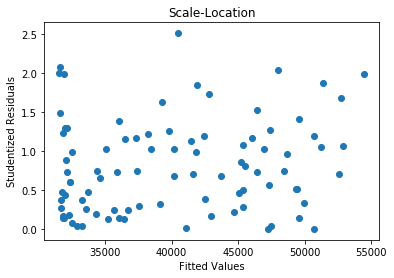

In [45]:
# Studentized residuals vs Fitted values - les résidus studentisés sont plus efficaces. cf. 
# https://medium.com/@aurliegiraud/perform-regression-diagnostics-and-tackle-uncertainties-of-linear-models-1372a03b1f56
student_residuals = pd.Series(np.abs(results.get_influence().resid_studentized_internal))
# Plot the Studentized Residual
fig, ax = plt.subplots()
plt.scatter(results.fittedvalues, student_residuals)
plt.ylabel('Studentized Residuals')
plt.xlabel('Fitted Values')
plt.title('Scale-Location')
# plt.show()
plt.savefig('fig5c.jpeg')

Résidus petits et non structurés (pas de cluster) --> OK

##### Normalité

C:\Users\Zang\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


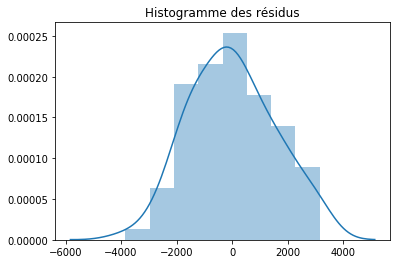

In [32]:
sns.distplot(results.resid).set_title('Histogramme des résidus')

# plt.savefig('fig6.jpeg')

L'hypothèse de normalité semble se confirmer. 

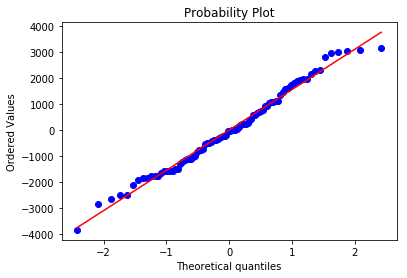

In [47]:
# on affiche le Q-Q plot (cf. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)
fig, ax = plt.subplots()
qqp = st.probplot(results.resid, plot=ax, fit=True)

# plt.savefig('fig7.jpeg')

Les résidus semblent respecter une distribution gaussienne.

In [67]:
# Shapiro p-value
st.shapiro(results.resid)

(0.9854924082756042, 0.4188325107097626)

p-value > 0.05 => On ne peut pas rejeter H0 selon laquelle la distribution des résidus est conforme à une distribution normale.

##### Indépendance des résidus

La prochaine hypothèse que nous devons vérifier est que les résidus sont indépendants (= qu'ils ne sont pas autocorréllés).   
Nous pouvons le faire avec le test Durbin-Watson.

In [68]:
from statsmodels.stats.stattools import durbin_watson

In [69]:
durbin_watson(results.resid, axis=0)

1.9138132356687343

Nos résidus sont "normaux" (cf. paragraphe ci-dessous). 

**Rappel :**  
The Durbin-Watson statistic is a direct test of the correlation of the residuals. It takes a value from 0 to 4, where:  
2 means no autocorrelation.  
0 to 2 means positive autocorrelation.  
2 to 4 means negative autocorrelation.  
As a rule of thumb, values in the range of 1.5 to 2.5 are relatively normal.  
cf. https://openclassrooms.com/fr/courses/5873596-design-effective-statistical-models-to-understand-your-data/6232921-check-assumptions-of-regression#:~:text=If%20you%20recall%20the%20results,2%20means%20no%20autocorrelation.

##### Variance des résidus (homoscedasticité)

In [74]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [75]:
# Test de Breusch Pagan
# cf. https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 1.3363454080402093),
 ('p-value', 0.24767949254732213),
 ('f-value', 1.3263427550865048),
 ('f p-value', 0.25257622919522954)]

p-value > 0.05 => nous ne pouvons pas rejeter l’hypothèse nulle d’homoscédasticité des résidus.

#### Correction des données de consommation mensuelle de l'effet température

In [7]:
# Je retire l'effet température de la consommation électrique
data['conso_corr'] = data['consommation'] - (data['dju'] * results.params['dju'])

In [9]:
# Pour info (cf. results.summary())
results.params

const    31563.133789
dju         48.902522
dtype: float64

Text(0,0.5,'consommation')

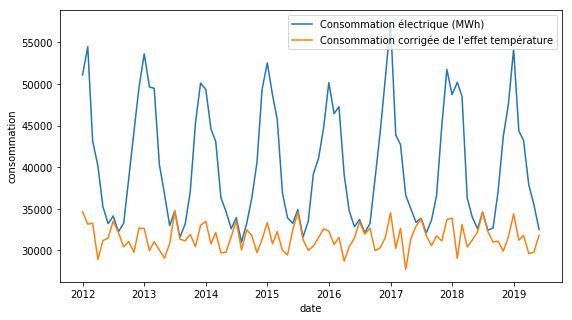

In [49]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(data["consommation"], label="Consommation électrique (MWh)")
plt.plot(data["conso_corr"], label="Consommation corrigée de l'effet température")
plt.legend()
plt.xlabel('date')
plt.ylabel('consommation')

# plt.savefig('fig9.jpeg')

<a id='2.Désaisonnalisation'></a>

[Haut de page](#Top) 

## 2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles.

cf. 
- https://openclassrooms.com/fr/courses/4525371-analysez-et-modelisez-des-series-temporelles/4834996-desaisonnalisez-a-laide-des-moyennes-mobiles 
- https://openclassrooms.com/fr/courses/4525371-analysez-et-modelisez-des-series-temporelles/5001626-decouvrez-des-algorithmes-de-traitement-des-moyennes-mobiles

On utilise la fonction "seasonal_decompose" du package statsmodels.  L'algorithme est basé sur les moyennes mobiles. cf. https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html   
Les saisons ont une période de 1 an, nous allons donc les calculer sur 12 valeurs (12 mois).

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
data.head()

,consommation,dju,conso_corr
mois,,,
2012-01-01,51086,336.0,34654.752443
2012-02-01,54476,435.9,33159.390447
2012-03-01,43156,201.9,33282.580709
2012-04-01,40176,230.3,28913.749071
2012-05-01,35257,83.3,31183.419877


In [33]:
# Enregistrement
data.to_csv('C:/Users/Zang/Documents/APPRENDER/OPENCLASSROOMS/PARCOURS DA/P9_Predisez_la_demande_en_electricite/datawcc.csv')

In [5]:
# Import (si besoin)
data = pd.read_csv('C:/Users/chal1/OneDrive/Documents/APPRENDER/DATA_ANALYST_OCR/DONNEES/P9/datawcc.csv')
data.set_index('mois', inplace = True)

In [3]:
data.head()

,consommation,dju,conso_corr
mois,,,
2012-01-01,51086,336.0,34654.752443
2012-02-01,54476,435.9,33159.390447
2012-03-01,43156,201.9,33282.580709
2012-04-01,40176,230.3,28913.749071
2012-05-01,35257,83.3,31183.419877


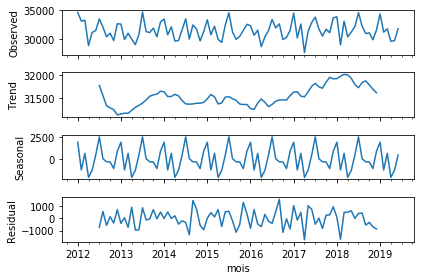

In [39]:
# Choix du modèle additif. En effet l'écart entre le mini et la maxi sur l'année reste à peu près stable au cours du temps
decomp_cc = seasonal_decompose(data.conso_corr,  model='additive')
decomp_cc_graph = decomp_cc.plot()

# plt.savefig('fig10.jpeg')

On obtient donc : 
- la tendance (traduit le niveau moyen de la série temporelle) - ici ascendante
- la saisonnalité (l'ensemble des fluctualités que l'on retrouve dans la série temporelle, quelque chose de périodique)
- les résidus (la part que l'on ne peut expliquer)

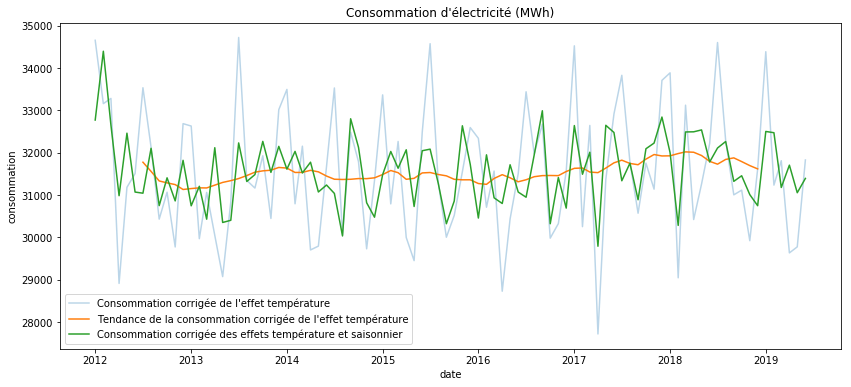

In [40]:
fig, ax = plt.subplots(figsize=(14,6))

plt.plot(data.conso_corr, label="Consommation corrigée de l'effet température", alpha=0.30)
plt.plot(decomp_cc.trend, label="Tendance de la consommation corrigée de l'effet température")
plt.plot(data.conso_corr - decomp_cc.seasonal, label="Consommation corrigée des effets température et saisonnier")

plt.title('Consommation d\'électricité (MWh)')
plt.legend()
plt.xlabel('date')
plt.ylabel('consommation')

# plt.savefig('fig11.jpeg')

<a id='3.Previsiondelaconsommation'></a>

[Haut de page](#Top) 

## 3. Prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt-Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle

<a id='HoltWinters'></a>

### 3.1. Prévision selon la méthode Holt-Winters

cf. 
- https://openclassrooms.com/fr/courses/4525371-analysez-et-modelisez-des-series-temporelles/5001326-tp-prevoyez-une-serie-a-l-aide-des-methodes-de-lissage-exponentiel
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [5]:
# cf. https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
from statsmodels.tsa.api import ExponentialSmoothing

In [7]:
# Définition de variables pour la suite
y = data.conso_corr
# Tout sauf les 12 derniers mois :
y_tronc = y[:-12]
# les 12 derniers mois : 
y_a_prevoir = y[-12:]

In [16]:
# Vérification d'usage
y.describe()

count       90.000000
mean     31563.133789
std       1533.951389
min      27720.399393
25%      30433.912214
50%      31507.296172
75%      32621.099053
max      34721.658487
Name: conso_corr, dtype: float64

In [8]:
# Modèle
hw_meth = ExponentialSmoothing(np.asarray(y), seasonal_periods=12,trend='add', seasonal='add').fit()
# Prévision
prev_hw_meth = hw_meth.forecast(12)

In [89]:
# Pour voir
hw_meth.params

{'smoothing_level': 0.05263157894736842,
 'smoothing_slope': 0.05263157894736842,
 'smoothing_seasonal': 0.3684210526315789,
 'damping_slope': nan,
 'initial_level': 33660.34956638838,
 'initial_slope': 0.0,
 'initial_seasons': array([  994.40287701,  -500.95911972,  -377.76885709, -4746.60049581,
        -2476.92968979, -2152.93785353,  -125.74084526, -1530.71562036,
        -3227.6958708 , -2592.67954332, -3885.27672789,  -973.73209564]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

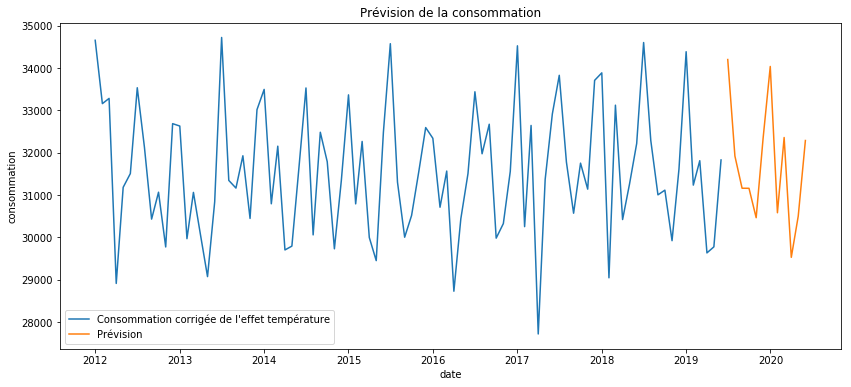

In [90]:
# Représentation
fig, ax = plt.subplots(figsize=(14,6))
plt.plot(y, label='Consommation corrigée de l\'effet température')
plt.plot(pd.date_range(data.index[len(y)-1], periods=12, freq='M'), prev_hw_meth, label='Prévision')
# plt.legend()
plt.xlabel('date')
plt.ylabel('consommation')
plt.title('Prévision de la consommation avec la méthode Holt-Winters')
leg = plt.legend()
# plt.savefig('fig12.jpeg')

#### Analyse a posteriori

In [21]:
# création du modèle selon les mêmes critères que précédemment
hw_meth_post = ExponentialSmoothing(np.asarray(y_tronc), seasonal_periods=12, trend='add', seasonal='add').fit()

# prévision
prev_hw_meth_post = hw_meth_post.forecast(12)

# ajout en index des dates correspondantes aux prévisions
prev_hw_meth_post = pd.Series(prev_hw_meth_post, index = y_a_prevoir.index)

In [22]:
# Vérification
prev_hw_meth_post

mois
2018-07-01    34101.881481
2018-08-01    31898.434297
2018-09-01    31456.272205
2018-10-01    31402.654910
2018-11-01    31053.259497
2018-12-01    33009.470264
2019-01-01    34013.365710
2019-02-01    30235.480544
2019-03-01    32943.774159
2019-04-01    29703.228364
2019-05-01    31199.597095
2019-06-01    32637.931885
dtype: float64

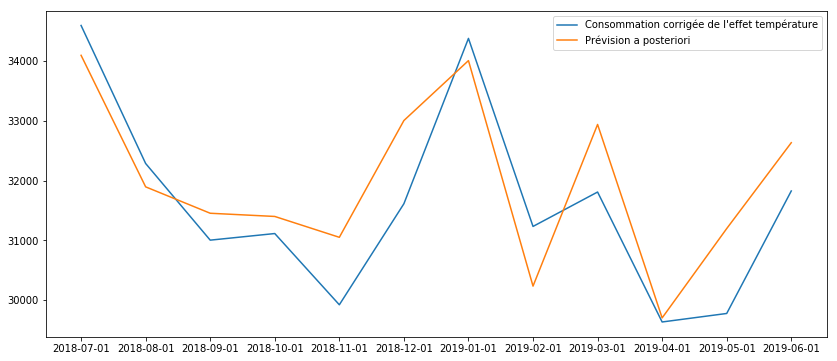

In [29]:
# nous allons afficher les n derniers mois
nb_mois = 12
plt.figure(figsize=(14,6))
plt.plot(y[-nb_mois:], label="Consommation corrigée de l'effet température")
plt.plot(prev_hw_meth_post.iloc[-nb_mois:], label='Prévision a posteriori')

plt.legend()

plt.savefig('fig12b.jpeg');

La prévision semble très correcte, elle suit bien la courbe de la consommation corrigée. 

On calcule le RMSE et la MAPE.

In [26]:
# Root Mean Squared Error 
rmse_HW = np.sqrt(((prev_hw_meth_post - y_a_prevoir) ** 2).mean())
print('Le RMSE est de {}'.format(round(rmse_HW, 2)))

Le RMSE est de 866.46


In [28]:
# Mean Average Percentage Error ou erreur relative absolue moyenne
mape_HW = (np.abs(1- y_a_prevoir / prev_hw_meth_post)).mean() * 100
print('La MAPE est de {}'.format(round(mape_HW, 2)) + '%')

La MAPE est de 2.33%


<a id='SARIMA'></a>

[Haut de page](#Top) 

### 3.2. Prévision selon la méthode SARIMA

SARIMA = Seasonal Autoregressive Moving Average  

**Rappel :**

Un processus est stationnaire si :
- l'esperance est constante a travers le temps
- la variance est constante a travers le temps
- les autocorélations entre deux moments séparés dans le temps sont constantes  

cf. https://openclassrooms.com/fr/courses/4525371-analysez-et-modelisez-des-series-temporelles/5001251-tp-prevoyez-une-serie-temporelle-a-l-aide-des-methodes-sarima  et https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

#### Stationnarisation de la série

In [4]:
from statsmodels.tsa.stattools import acf, pacf
from functions import plot_sortie_acf

In [105]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##### autocorrélogrammes

cf. http://perso.ens-lyon.fr/lise.vaudor/autocorrelation-de-series-temporelles-ou-spatiales/

Diagramme de corrélation simple sans appliquer de différenciations à y : 

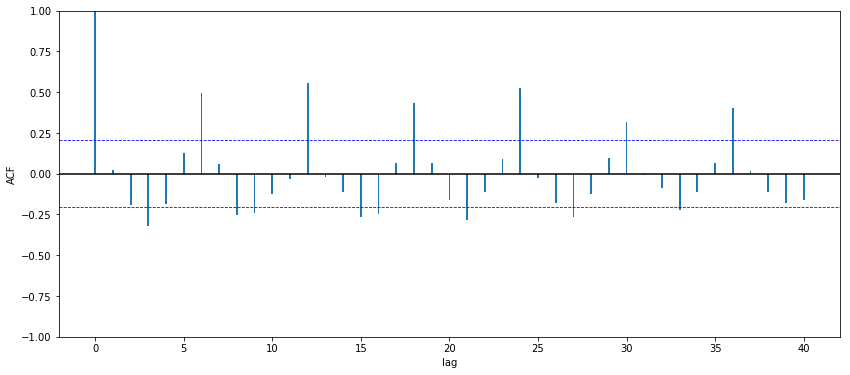

In [7]:
# y_len = len(data.conso_corr) # variable pour l'utilisation de plot_sortie_acf
plot_sortie_acf(acf(np.asarray(y)), len(y))

# plt.savefig('fig13.jpeg')

*On effectue une différenciation en saisonnalité donc D=1.*

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation  $(I−B)$.

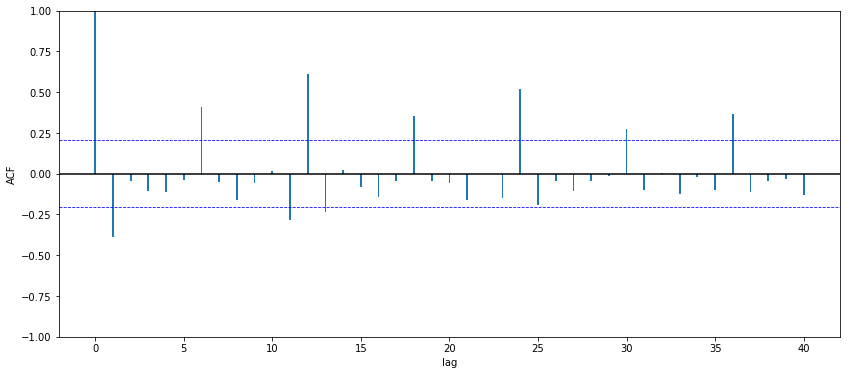

In [9]:
y_dif1 = (y - y.shift(1))
plot_sortie_acf(acf(np.asarray(y_dif1[1:])), len(y))

# plt.savefig('fig14.jpeg')

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0. On effectue cette fois la différenciation $(I−B^{12})$ .

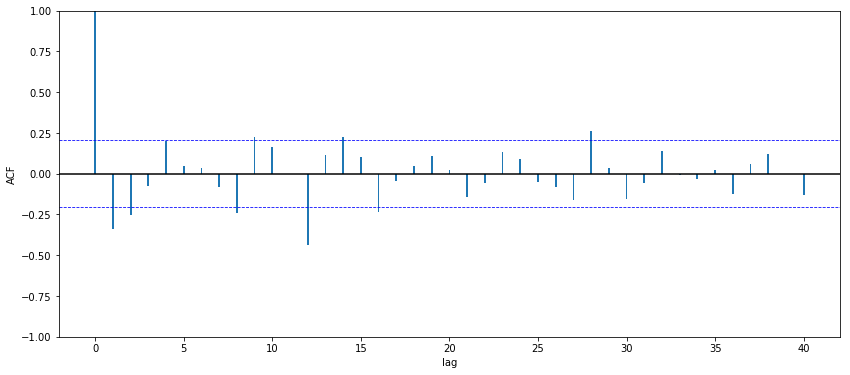

In [10]:
y_dif_1_12 = y_dif1 - y_dif1.shift(12)
plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), len(y))

# plt.savefig('fig15.jpeg')

La sortie ACF de la série doublement différenciée semble pouvoir être interprétée comme un autocorrélogramme simple empirique.

#### Identification, estimation et validation de modèles

On s’appuie sur les autocorrélogrammes simple et partiels estimés :

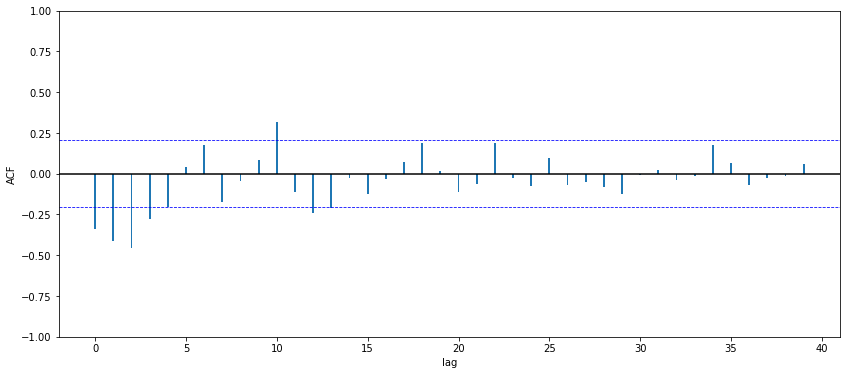

In [101]:
plot_sortie_acf(pacf(np.asarray(y_dif_1_12[13:]), method='ldb'), len(y), pacf=True)

# plt.savefig('fig16.jpeg')

On ne constate plus de pics significatifs (au dessus des pointillés, qui représentent le seuil à 5%) à intervalle régulier.

Une différenciation de $(I -B^{12})$ semble suffir pour stationnarier la série temporelle.

#### SARIMA

Voir : 
- https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
- https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [4]:
from statsmodels.tsa.statespace.sarimax import *
# Test de Ljung–Box permettant de vérifier que le résidu est bien un bruit blanc
from statsmodels.stats.diagnostic import acorr_ljungbox

##### Modèle

cf. https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459

Au vu des autocorrélogrammes empiriques simples et partiels, on peut estimer plusieurs modèles. J'ai commencé par SARIMA(1,1,1)x(1,1,1) puis SARIMA(1,1,1)x(0,1,1) qui ne sont pas satisfaisants. Le modèle suivant a des paramètres significatifs :  

$$ (I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t}$$

In [16]:
model1 = SARIMAX(np.asarray(y), 
                 order=(0,1,1), 
                 seasonal_order=(0,1,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False)
results1 = model1.fit()
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -522.952
Date:                            Wed, 08 Jul 2020   AIC                           1051.903
Time:                                    15:33:29   BIC                           1058.333
Sample:                                         0   HQIC                          1054.432
                                             - 90                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0002      0.218     -4.595      0.000      -1.427      -0.574
ma.S.L12      -0.5915      0.074   

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

In [12]:
# Test de normalité des résidus
shapiro(results1.resid)

(0.4149114489555359, 3.164108448952935e-17)

Le test de normalité est également validé pour ce modèle.

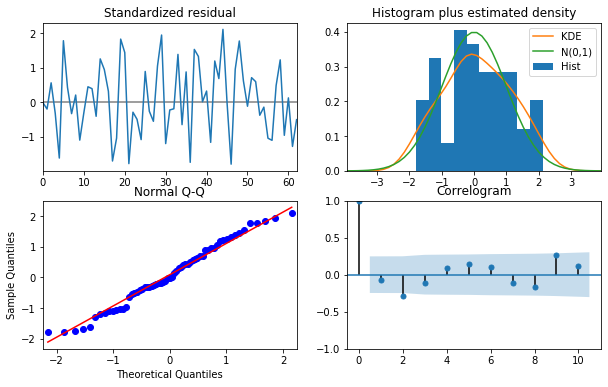

In [7]:
# Vérifions que les hypothèses de notre modèle sont respectées
results1.plot_diagnostics(figsize=(10, 6))
plt.show();
# plt.savefig('fig17.jpeg')

Nous pouvons confirmer que nos résidus sont indépendants et distribués selon la loi Normale.  

On voit que : 
- les points sont bien répartis sur la diagonale du QQ plot.
- La Kernel Density Estimation (KDE) plot des résidus correspond à celle d'une distribution normale.
- il n'y a pas d'hétéroscédasticité des résidus, qui correspondent à un [bruit blanc](https://fr.wikipedia.org/wiki/Bruit_blanc).
- L'autocorrélation montrée grâce au corrélogramme a une faible corrélation pour les lags > 0  
cf. https://medium.com/@rrfd/sarima-modelling-for-car-sharing-basic-data-pipelines-applications-with-python-pt-1-75de4677c0cd et https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

---

**_--- Pour trouver le meilleur modèle, nous pouvons aussi utiliser un algorithme._** 

Après plusieurs essais de différents algorithmes, celui ci-dessous donne les meilleurs résultats. Ceci dit, même si les résultats que nous obtenons sont tout à fait satisfaisants, nous avons considéré un nombre restreint de combinaisons de paramètres. Le modèle peut probablement encore être amélioré.

cf. https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [13]:
import itertools

In [19]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 0, 1) x (0, 1, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)


In [26]:
%%time

# import warnings
warnings.filterwarnings("ignore")

# Df pour stocker nos résultats
grid_search_results = pd.DataFrame({'modele':[], 'AIC':[], 'BIC':[]})

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y,
                          order = param,
                          seasonal_order = param_seasonal,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            
            # on stocke les résultats de notre modèle
            grid_search_results = grid_search_results.append({'modele':f"{param}x{param_seasonal}", 
                            'AIC':results.aic, 
                            'BIC':results.bic}, 
                            ignore_index=True)
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except: 
            continue

Wall time: 9.45 s


In [34]:
grid_search_results.sort_values('AIC').head(5)

,modele,AIC,BIC
27,"(0, 1, 1)x(0, 1, 1, 12)",1051.903408,1058.332812
31,"(0, 1, 1)x(1, 1, 1, 12)",1053.092932,1061.665471
59,"(1, 1, 1)x(0, 1, 1, 12)",1053.109104,1061.681643
63,"(1, 1, 1)x(1, 1, 1, 12)",1065.013496,1075.729169
15,"(0, 0, 1)x(1, 1, 1, 12)",1068.159660,1076.795193


_According Peterson, T. (2014) the AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The low AIC value the better._ cf. https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d

Avec AIC = 1051.90340779906, cela nous confirme que la meilleure combinaison est (0, 1, 1)x(0, 1, 1, 12)12

**_--- Autre possibilité : utiliser auto_arima de pyramid-arima (pmdarima)_** 

cf. ici par ex : https://medium.com/@chantrapornchai/energy-consumption-prediction-with-auto-arima-66e530a3f673, https://alkaline-ml.com/pmdarima/tips_and_tricks.html et https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [10]:
stepwise_model = auto_arima(data["conso_corr"], m = 12,
                           D = 1, seasonal = True,
                           trace = True,
                           error_action = 'ignore',  
                           suppress_warnings = True, 
                           stepwise = True,
                            information_criterion = 'aic')
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,1,1,12) [intercept=True]; AIC=1332.920, BIC=1351.773, Time=0.727 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=1339.192, BIC=1343.906, Time=0.000 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=1338.209, BIC=1347.636, Time=0.125 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=1337.517, BIC=1346.944, Time=0.151 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=1337.270, BIC=1339.627, Time=0.016 seconds
Fit ARIMA(2,0,2)x(0,1,1,12) [intercept=True]; AIC=1330.950, BIC=1347.447, Time=0.379 seconds
Fit ARIMA(2,0,2)x(0,1,0,12) [intercept=True]; AIC=1331.647, BIC=1345.787, Time=0.133 seconds
Fit ARIMA(2,0,2)x(0,1,2,12) [intercept=True]; AIC=1332.897, BIC=1351.750, Time=1.111 seconds
Fit ARIMA(2,0,2)x(1,1,0,12) [intercept=True]; AIC=1330.971, BIC=1347.468, Time=0.467 seconds
Fit ARIMA(2,0,2)x(1,1,2,12) [intercept=True]; AIC=1333.044, BIC=1354.255, Time=2.379 seconds
Near non-invertible roots 

Mais on constate des résultats (AIC) moins bons que précédemment. Nous resterons sur le modèle (0, 1, 1)x(0, 1, 1, 12)12. 

---

#### Prévision à l’aide du modèle retenu

In [17]:
# Nous allons faire une prévision sur un an
pred_model1 = results1.get_forecast(12)
pred = pred_model1.predicted_mean
pred_l = [elt[0] for elt in pred_model1.conf_int(alpha=0.05)]
pred_u = [elt[1] for elt in pred_model1.conf_int(alpha=0.05)]

In [18]:
data.index = pd.to_datetime(data.index)

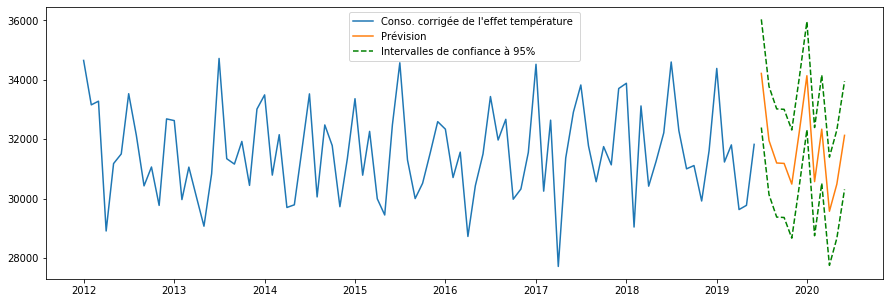

In [19]:
plt.figure(figsize=(15,5))
plt.plot(data.index, data.conso_corr, label='Conso. corrigée de l\'effet température ')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred, label='Prévision')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--', 
         label='Intervalles de confiance à 95%')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')

plt.legend()
# plt.show()
# plt.savefig('fig18.jpeg')

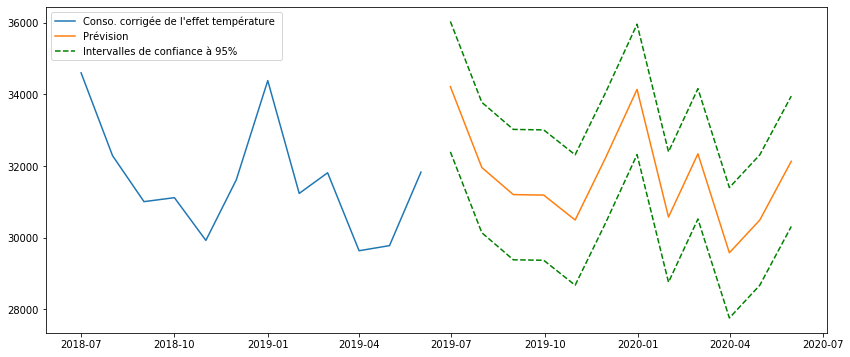

In [42]:
# Affichage des 24 derniers mois
# pred_model2 = result.get_forecast(12)
# pred2 = pred_model2.predicted_mean
# pred_l2 = [elt[0] for elt in pred_model2.conf_int(alpha=0.05)]
# pred_u2 = [elt[1] for elt in pred_model2.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(data.index[-12:],data.conso_corr[-12:], label='Conso. corrigée de l\'effet température ')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred, label='Prévision')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--', 
         label='Intervalles de confiance à 95%')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')

plt.legend()
plt.show()
# plt.savefig('fig19.jpeg')

#### Analyse a posteriori

In [34]:
# x_tronc = data.index[:-12]
# y_tronc = data.conso_corr[:-12]
# x_a_prevoir = data.index[-12:]

In [ ]:
# # Définition de variables pour la suite
# y = data.conso_corr
# y_tronc = y[:-12]
# y_a_prevoir = y[-12:]

On vérifie que le modèle 1 sur la série tronquée est toujours validé.

In [26]:
model1_tronc = SARIMAX(np.asarray(y_tronc),
                       order=(0, 1, 1),
                       seasonal_order=(0, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
result1_tronc = model1_tronc.fit()
print(result1_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(result1_tronc.resid, lags=elt)[1].mean()))
    
shapiro(result1_tronc.resid)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   78
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -425.455
Date:                            Wed, 08 Jul 2020   AIC                            856.911
Time:                                    15:47:05   BIC                            862.706
Sample:                                         0   HQIC                           859.125
                                             - 78                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9839      0.207     -4.744      0.000      -1.390      -0.577
ma.S.L12      -0.5189      0.105   

(0.43100035190582275, 7.709942172441306e-16)

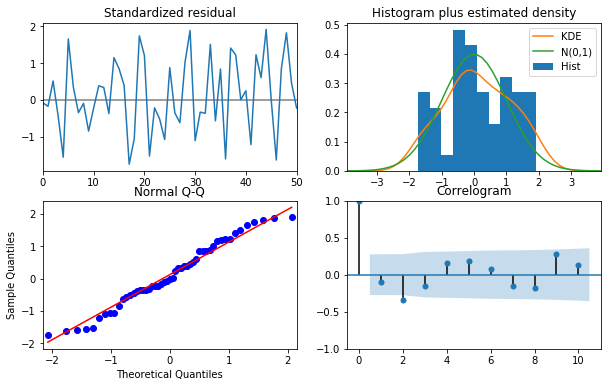

In [27]:
result1_tronc.plot_diagnostics(figsize=(10, 6))
plt.show();

In [28]:
pred_model1_tronc = result1_tronc.get_forecast(12)
pred_tronc = pred_model1_tronc.predicted_mean
pred_l_tronc = [elt[0] for elt in pred_model1_tronc.conf_int(alpha=0.05)]
pred_u_tronc = [elt[1] for elt in pred_model1_tronc.conf_int(alpha=0.05)]

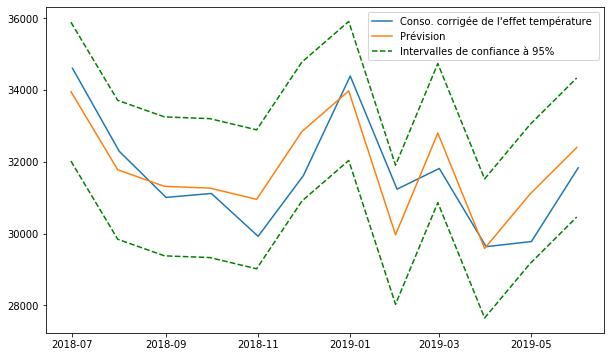

In [30]:
plt.figure(figsize=(10,6))

plt.plot(data.index[-12:],data.conso_corr[-12:], label='Conso. corrigée de l\'effet température ')

plt.plot(pd.date_range(data.index[(len(data)-12)-1], periods=12, freq='M'), pred_tronc, label='Prévision')
plt.plot(pd.date_range(data.index[(len(data)-12)-1], periods=12, freq='M'), pred_l_tronc, color='g', linestyle='--',
         label='Intervalles de confiance à 95%')
plt.plot(pd.date_range(data.index[(len(data)-12)-1], periods=12, freq='M'), pred_u_tronc, color='g', linestyle='--')

plt.legend()
# plt.savefig('fig20.jpeg')

On constate que notre modèle englobe bien de mi-2018 à juin 2019 sur un intervalle de confiance à 95%. 

On calcule les RMSE et MAPE.

In [32]:
# Root Mean Squared Error 
rmse = np.sqrt(((pred - y[-12:]) ** 2).mean())
print('Le RMSE est de {}'.format(round(rmse, 2)))

Notre RMSE est de 446.18


In [34]:
# Mean Squared Error (erreur quadratique moyenne)
mse = ((pred  -y[-12:]) ** 2).mean()
print('L\'erreur quadratique est de {}'.format(round(mse, 2)))

L'erreur quadratique est de 199079.1


In [40]:
# Mean Average Percentage Error ou erreur relative absolue moyenne
mape = (np.abs(1- data.conso_corr[-12:] / pred)).mean() * 100
print('La MAPE est de {}'.format(round(mape, 2)) + '%')

La MAPE est de 1.23%
